In [1]:
import pandas as pd
import numpy as np
import numpy as np
np.float_ = np.float64
import matplotlib.pyplot as plt 
from prophet import Prophet

In [2]:
# Load the dataset
data = pd.read_csv('/Users/dave.john.98/Desktop/APAN/Fall 24/Anomaly Detection/Week 1/archive/PJME_hourly.csv')
data.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [3]:
# Check for Null Values
data.isna().sum()

Datetime    0
PJME_MW     0
dtype: int64

In [4]:
# Data summary 
data.describe()

,PJME_MW
count,145366.000000
mean,32080.222831
std,6464.012166
min,14544.000000
25%,27573.000000
50%,31421.000000
75%,35650.000000
max,62009.000000


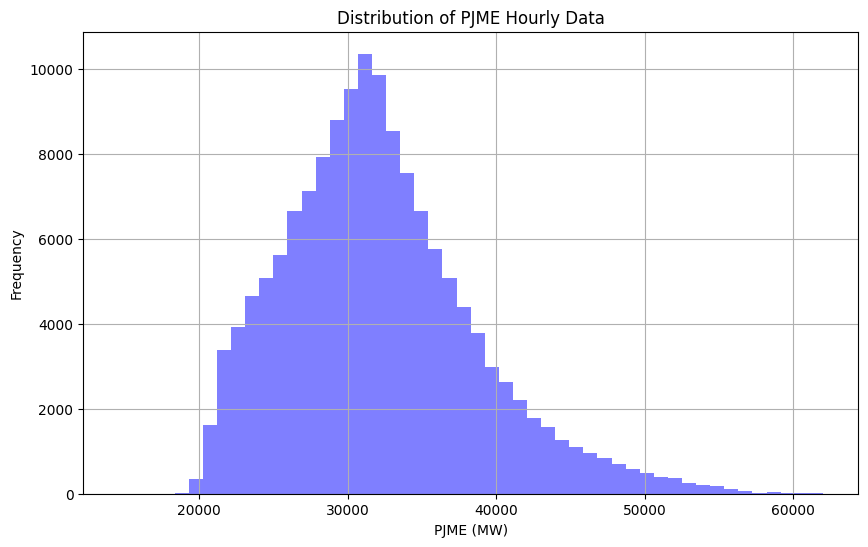

In [5]:
# Check the data's distribution

plt.figure(figsize=(10, 6))
plt.hist(data['PJME_MW'], bins=50, color='blue', alpha=0.5)
plt.title('Distribution of PJME Hourly Data')
plt.xlabel('PJME (MW)')
plt.ylabel('Frequency')
plt.grid(True)

plt.show()


###### *Observation: Most values seem to cluster between 25,000 MW and 40,000 MW*

## **1. Explore Simple Moving Average Model**

In [6]:
# Renaming the columns to make sure there are no hidden characters or issues
data.columns = data.columns.str.strip()

# Convert the 'Datetime' column to a datetime object again
data['Datetime'] = pd.to_datetime(data['Datetime'])

# Set the 'Datetime' column as the index
data.set_index('Datetime', inplace=True)

# Calculate the Simple Moving Average (SMA) with a 24-hour window
data['SMA_24'] = data['PJME_MW'].rolling(window=24).mean()


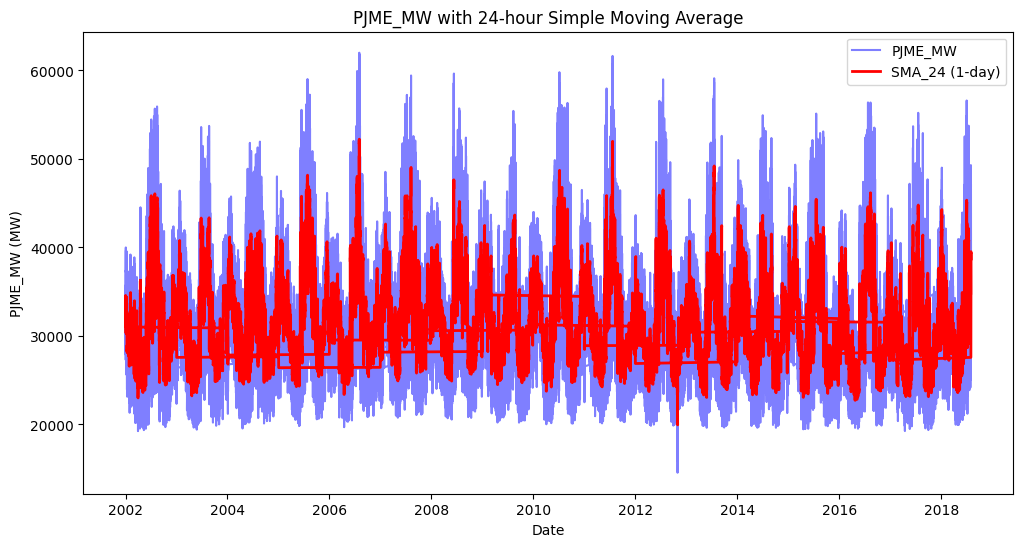

In [7]:
# Plot the original data and the choosing to keep '24-hour' Simple Moving Average
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['PJME_MW'], label='PJME_MW', color='blue', alpha=0.5)
plt.plot(data.index, data['SMA_24'], label='SMA_24 (1-day)', color='red', linewidth=2)

plt.xlabel('Date')
plt.ylabel('PJME_MW (MW)')
plt.title('PJME_MW with 24-hour Simple Moving Average')
plt.legend()

plt.show()

#### Instead of looking at this dataset from an hourly perspective, let's take make try making it daily:

In [8]:
# Convert the data to daily frequency and calculate the sum for each day
data_daily = data['PJME_MW'].resample('D').sum().reset_index()

# Rename the columns for clarity
data_daily.columns = ['Date', 'PJME_MW']

# Convert the 'Datetime' column to a datetime object
data_daily['Date'] = pd.to_datetime(data_daily['Date'])

# Set the 'Date' column as the index
data_daily.set_index('Date', inplace=True)

In [9]:
# Calculate the Simple Moving Average (SMA) with a 7 day (weekly) window
data_daily['SMA_weekly'] = data_daily['PJME_MW'].rolling(window=7).mean()

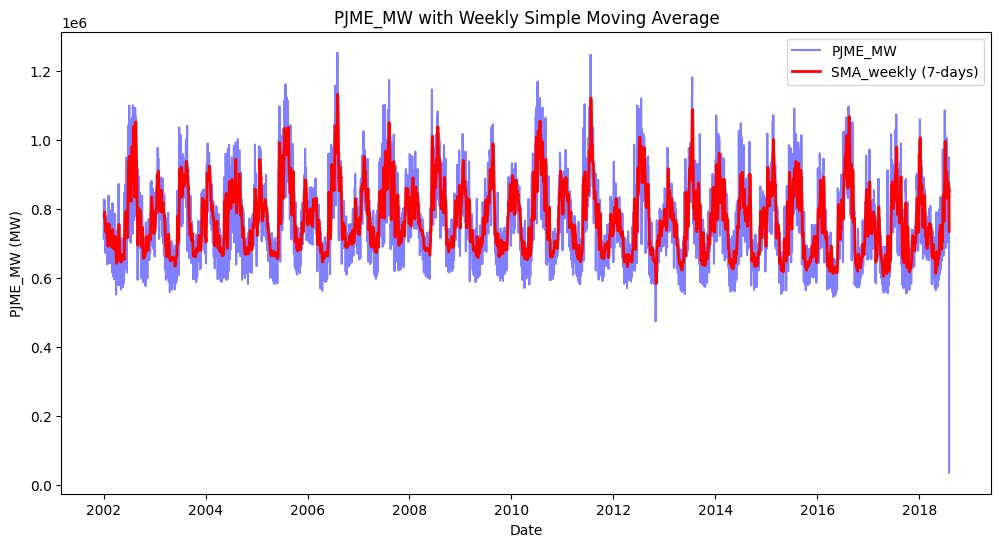

In [10]:
# Plot the original data and the choosing to keep 'weekly' Simple Moving Average
plt.figure(figsize=(12, 6))
plt.plot(data_daily.index, data_daily['PJME_MW'], label='PJME_MW', color='blue', alpha=0.5)
plt.plot(data_daily.index, data_daily['SMA_weekly'], label='SMA_weekly (7-days)', color='red', linewidth=2)

plt.xlabel('Date')
plt.ylabel('PJME_MW (MW)')
plt.title('PJME_MW with Weekly Simple Moving Average')
plt.legend()

plt.show()

#### Let's conduct some EDA and look for Anomalies

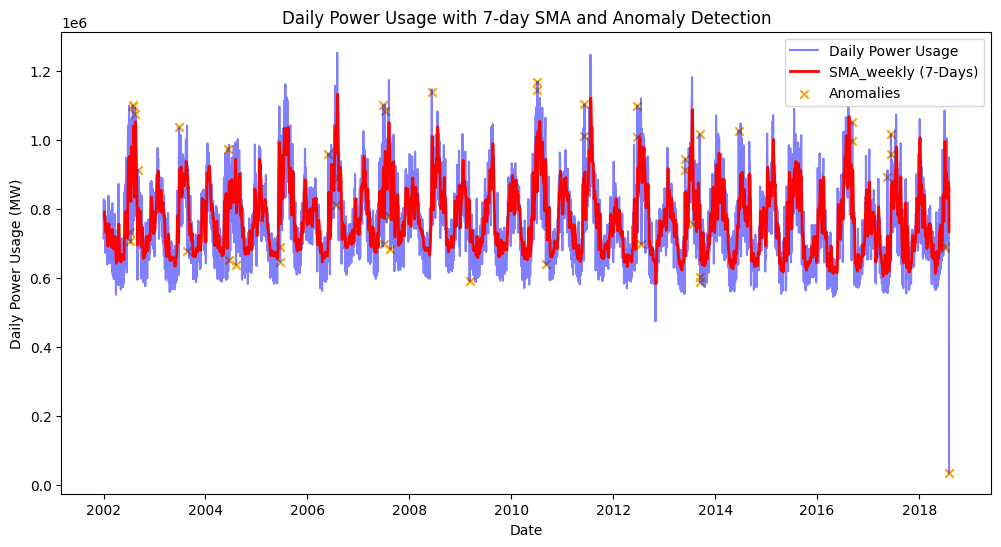

In [11]:
# Calculate the difference between daily data and SMA)
data_daily['diff'] = data_daily['PJME_MW'] - data_daily['SMA_weekly']

# Define a threshold for anomalies (Let's use 3 std deviations as the threshold)
sd = data_daily['diff'].std()
threshold = 3 * sd

# Identify anomalies (where the difference exceeds the threshold)
data_daily['Anomalies'] = data_daily['diff'].abs() > threshold

# Plot the original daily power usage, SMA, and highlight anomalies
plt.figure(figsize=(12, 6))
plt.plot(data_daily.index, data_daily['PJME_MW'], label='Daily Power Usage', color='blue', alpha=0.5)
plt.plot(data_daily.index, data_daily['SMA_weekly'], label='SMA_weekly (7-Days)', color='red', linewidth=2)

# Separate the anomalies into a new DataFrame
anomalies = data_daily[data_daily['Anomalies']]

anomalies.head()

# Highlight anomalies
plt.scatter(anomalies.index, anomalies['PJME_MW'], 
            color='orange', label='Anomalies', marker = 'x')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Daily Power Usage (MW)')
plt.title('Daily Power Usage with 7-day SMA and Anomaly Detection')
plt.legend()

# Display the plot
plt.show()

The Simple Moving Average (SMA) model **smooths out short-term fluctuations** in the data by **averaging power usage** over a set period (weekly or daily). This allows us to identify long-term trends, while **anomalies** are detected when the **actual values deviate significantly from the moving average**. By selecting a larger window, I was able to reduce noise and focus on significant deviations, such as abnormal spikes or drops in power usage that fall far from the trend line

## **2. Explore Exponential Smoothing Model**

In [12]:
from statsmodels.tsa.api import SimpleExpSmoothing

# Bring back the daily data dataset
data_daily = data['PJME_MW'].resample('D').sum().reset_index()
data_daily.columns = ['Date', 'PJME_MW']
data_daily['Date'] = pd.to_datetime(data_daily['Date'])
data_daily.set_index('Date', inplace=True)

data_daily.head()

,PJME_MW
Date,
2002-01-01,714857.0
2002-01-02,822277.0
2002-01-03,828285.0
2002-01-04,809171.0
2002-01-05,729723.0


/Users/dave.john.98/anaconda3/envs/APAN/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


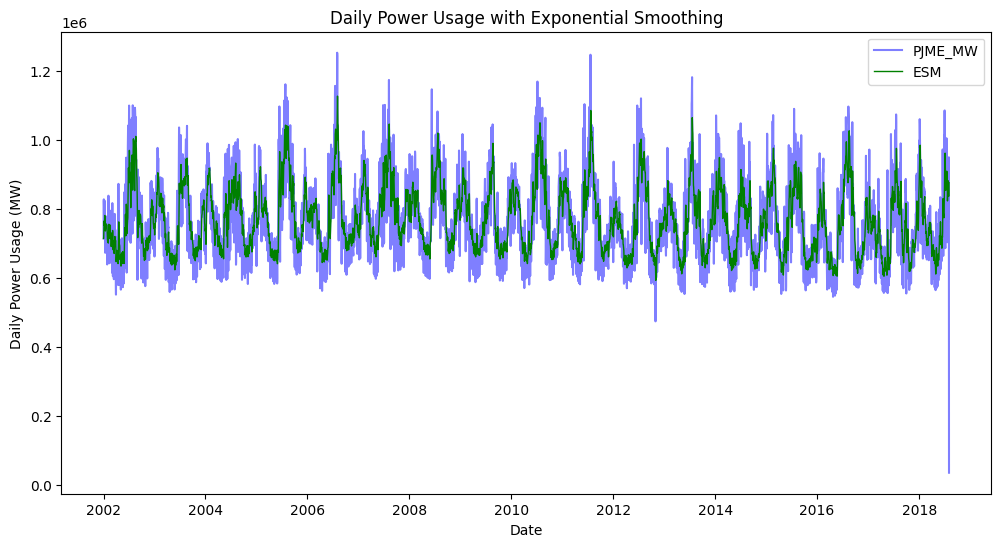

In [13]:
# Apply Exponential Smoothing
ESMfit = SimpleExpSmoothing(data_daily['PJME_MW']).fit(smoothing_level=0.2, optimized=False)
ESM = ESMfit.forecast(3).rename(r'$\alpha=0.2$')
data_daily['ESM'] = ESMfit.predict(start = 0)

# Plot the original data and the exponentially smoothed data
plt.figure(figsize=(12, 6))
plt.plot(data_daily.index, data_daily['PJME_MW'], label='PJME_MW', color='blue', alpha=0.5)
plt.plot(data_daily.index, data_daily['ESM'], label='ESM', color='green', linewidth=1)

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Daily Power Usage (MW)')
plt.title('Daily Power Usage with Exponential Smoothing')
plt.legend()

# Display the plot
plt.show()

#### *Let's take a look at a more zoomed in version of this taking data from the 2010 only*

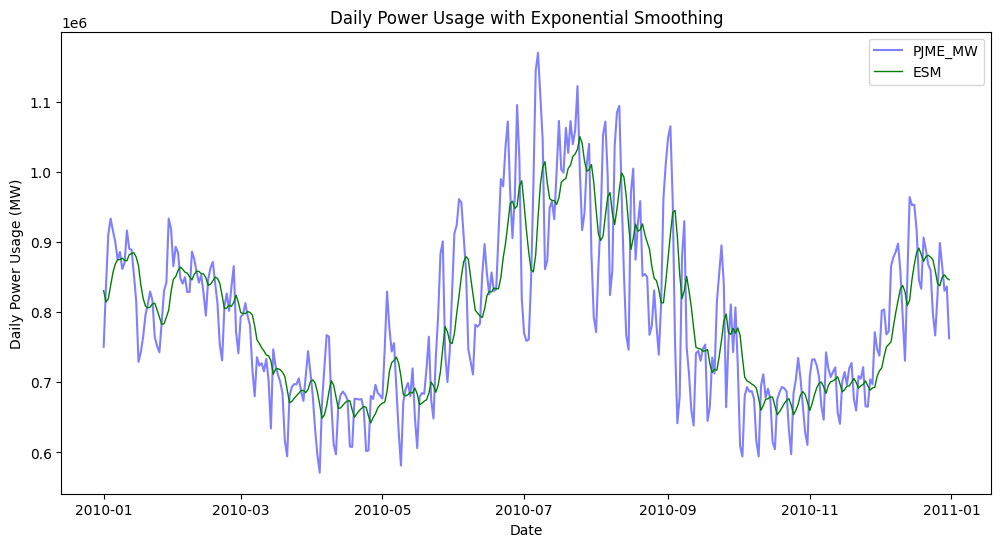

In [14]:
# Filter the dataset using loc for the year 2010
data_daily_2010 = data_daily.loc['2010']

# Create the plot again
plt.figure(figsize=(12, 6))
plt.plot(data_daily_2010.index, data_daily_2010['PJME_MW'], label='PJME_MW', color='blue', alpha=0.5)
plt.plot(data_daily_2010.index, data_daily_2010['ESM'], label='ESM', color='green', linewidth=1)

plt.xlabel('Date')
plt.ylabel('Daily Power Usage (MW)')
plt.title('Daily Power Usage with Exponential Smoothing')
plt.legend()

plt.show()



#### *Determine thresholds to use to detect anomalies*

In [15]:
# Calculate the difference (residual) between the original values and the ESM
data_daily_2010.loc[:, 'diff'] = data_daily_2010['PJME_MW'] - data_daily_2010['ESM']

# Calculate the standard deviation of the residuals (differences)
std_dev = data_daily_2010['diff'].std()

# We will use the threshold as 2 standard deviations
threshold = 2 * std_dev

/var/folders/sf/wx2npf5s5173yr23sxjzqyzh0000gn/T/ipykernel_43005/438330458.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_daily_2010.loc[:, 'diff'] = data_daily_2010['PJME_MW'] - data_daily_2010['ESM']


/var/folders/sf/wx2npf5s5173yr23sxjzqyzh0000gn/T/ipykernel_43005/3023357064.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_daily_2010['Anomalies'] = data_daily_2010['diff'].abs() > threshold


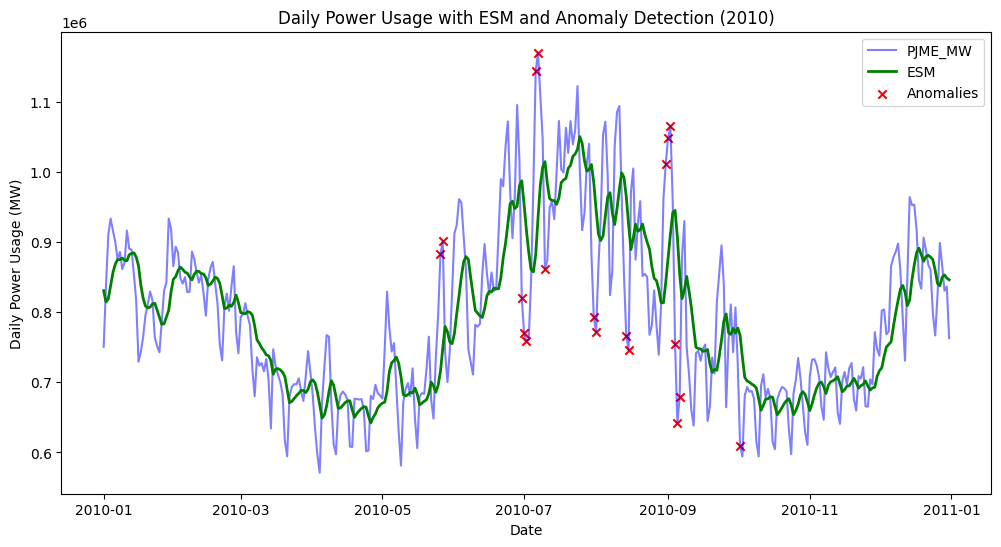

In [16]:
# Identify anomalies (where the absolute difference exceeds the threshold)
data_daily_2010['Anomalies'] = data_daily_2010['diff'].abs() > threshold

# Plot the data, ESM, and highlight anomalies
plt.figure(figsize=(12, 6))
plt.plot(data_daily_2010.index, data_daily_2010['PJME_MW'], label='PJME_MW', color='blue', alpha=0.5)
plt.plot(data_daily_2010.index, data_daily_2010['ESM'], label='ESM', color='green', linewidth=2)

# Separate the anomalies into a new DataFrame
anomalies = data_daily_2010[data_daily_2010['Anomalies']]

# Highlight anomalies
plt.scatter(anomalies.index, anomalies['PJME_MW'], 
            color='red', label='Anomalies', marker = 'x')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Daily Power Usage (MW)')
plt.title('Daily Power Usage with ESM and Anomaly Detection (2010)')
plt.legend()

# Display the plot
plt.show()


Exponential Smoothing places **more weight** on recent data, allowing the model to **respond to short-term changes**. **Residuals**, calculated as the difference between actual and predicted values, **help detect anomalies**. In this case, I used a threshold of ±2 standard deviations to mark potential anomalies. Residuals that exceed these boundaries indicate data points where the model prediction diverged significantly from actual power usage, signaling possible unusual behavior or outliers.

## **3. Explore Seasonal-Trend Decomposition**

In [17]:
# Bring back original hourly data:
data = pd.read_csv('/Users/dave.john.98/Desktop/APAN/Fall 24/Anomaly Detection/Week 1/archive/PJME_hourly.csv')
data['Datetime'] = pd.to_datetime(data['Datetime'])
data.columns = ['ds', 'y']

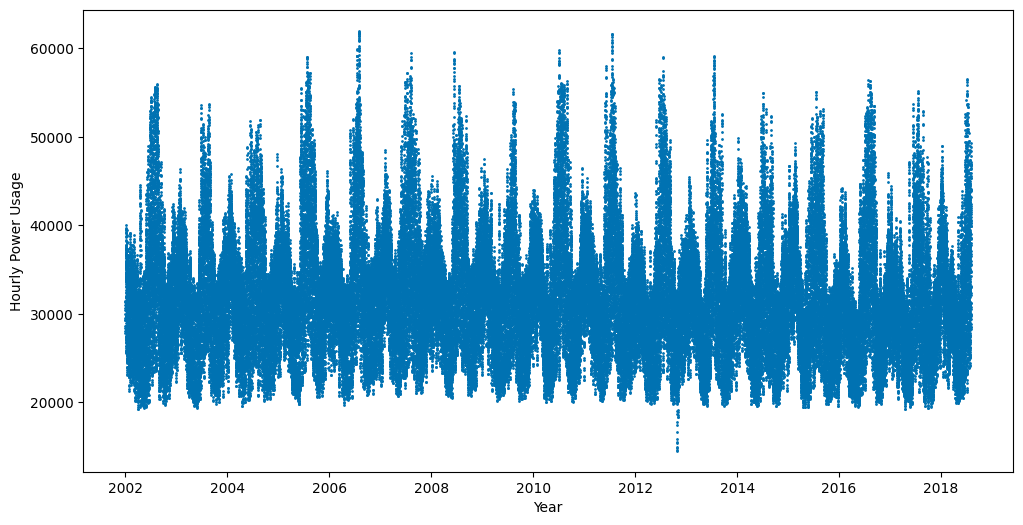

In [18]:
plt.figure(figsize=(12, 6))
plt.scatter(data['ds'], data['y'], s=1, c='#0072B2')
plt.xlabel('Year')
plt.ylabel('Hourly Power Usage')
plt.show()

23:03:15 - cmdstanpy - INFO - Chain [1] start processing
23:07:12 - cmdstanpy - INFO - Chain [1] done processing
/Users/dave.john.98/anaconda3/envs/APAN/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/dave.john.98/anaconda3/envs/APAN/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


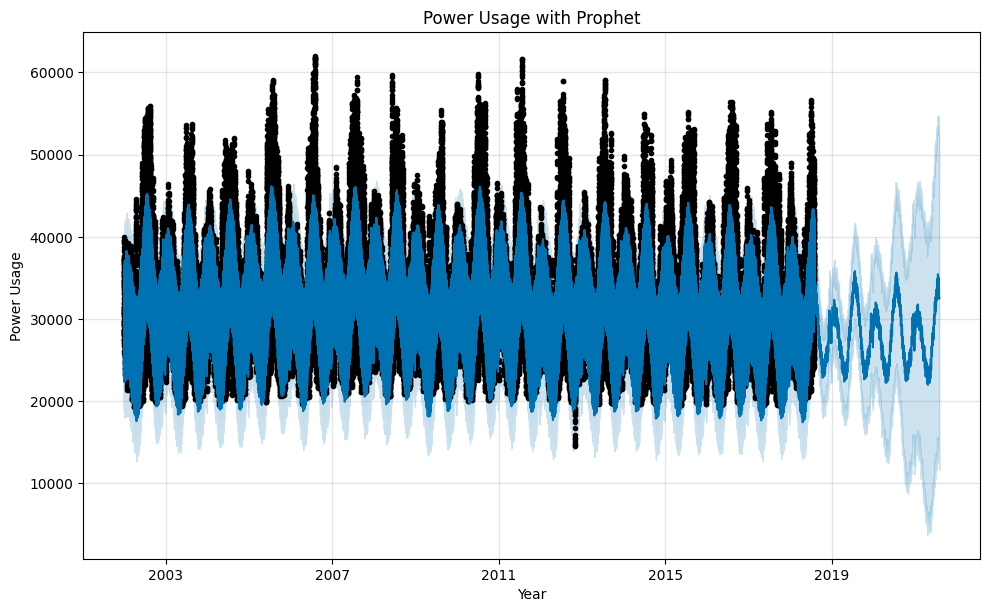

In [19]:
model = Prophet(seasonality_mode='additive',
                yearly_seasonality=20, weekly_seasonality=10)

model.fit(data)
future = model.make_future_dataframe(periods=365 * 3)
forecast = model.predict(future)

fig = model.plot(forecast, xlabel='Year', ylabel='Power Usage')
plt.title('Power Usage with Prophet')
plt.show()

/Users/dave.john.98/anaconda3/envs/APAN/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/dave.john.98/anaconda3/envs/APAN/lib/python3.11/site-packages/prophet/plot.py:397: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
/Users/dave.john.98/anaconda3/envs/APAN/lib/python3.11/site-packages/prophet/plot.py:401: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing

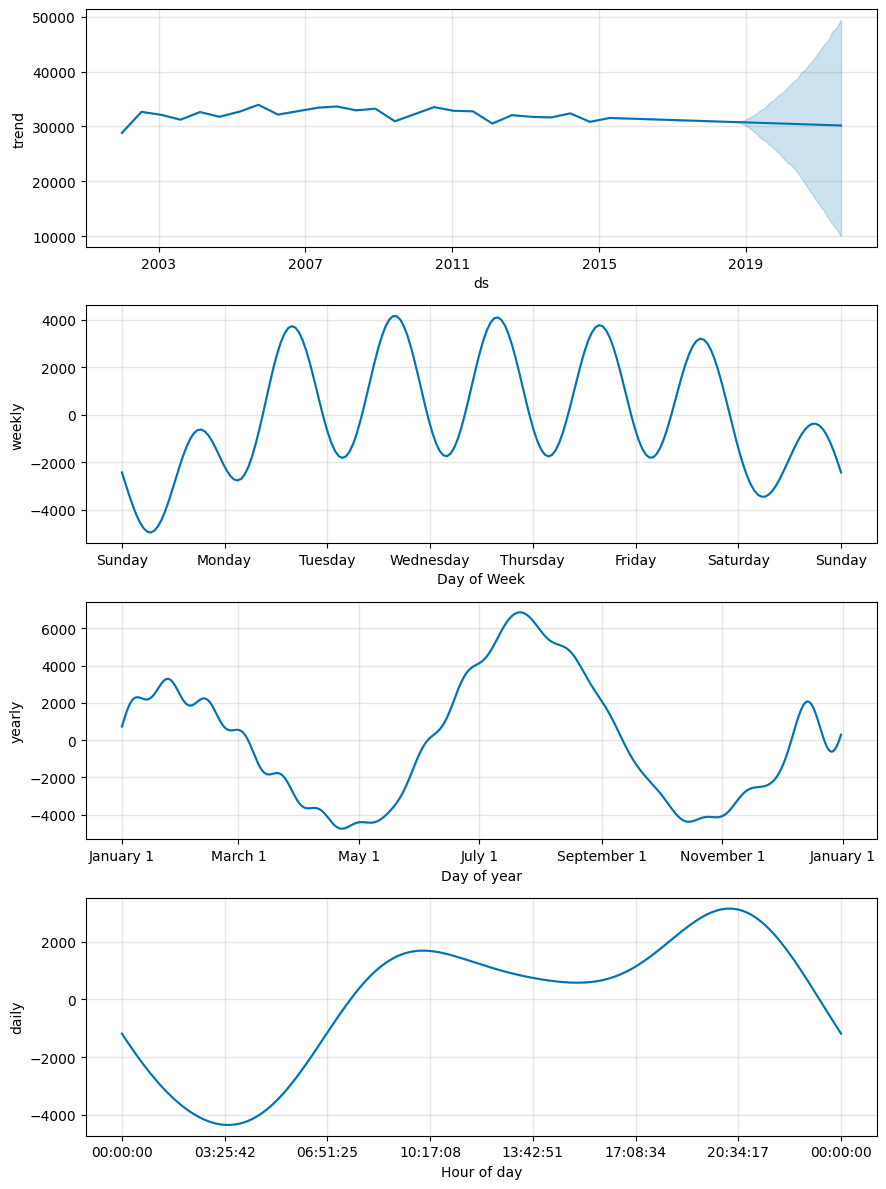

In [20]:
fig2 = model.plot_components(forecast)
fig2.savefig('/Users/dave.john.98/Desktop/components_plot.png')
plt.show()

The Prophet model decomposition shows a **stable long-term trend** in power usage, with noticeable **weekly** and **yearly** seasonality. Power consumption **peaks during weekdays and decreases on weekends**, while yearly trends show **higher usage in mid-summer**, likely due to cooling needs. Daily patterns align with typical human activity, **peaking during the day and dropping at night**.

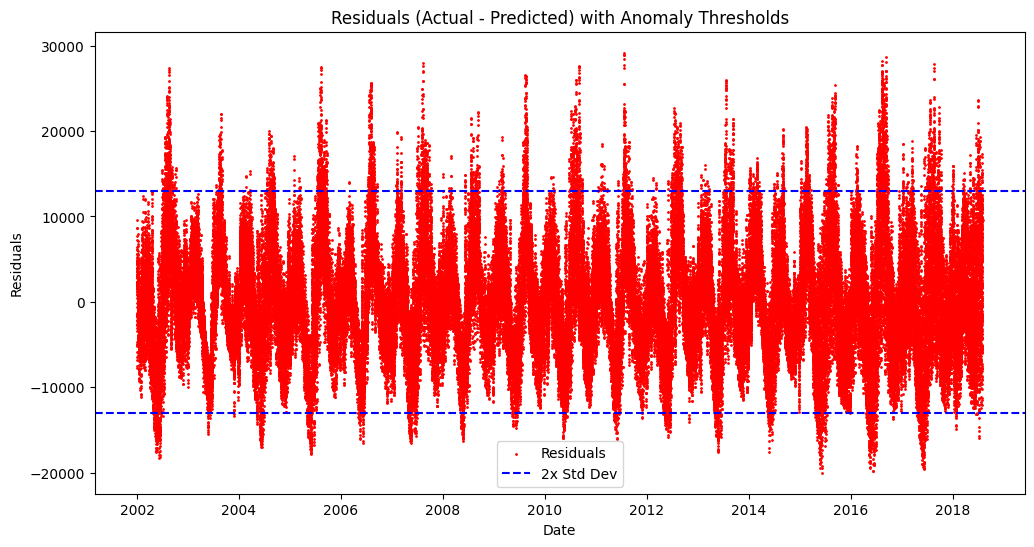

In [21]:
# Calculate residuals
data['residual'] = data['y'] - forecast['yhat']

# Calculate standard deviation of residuals
residual_std = data['residual'].std()

# Plot residuals with thresholds (2 standard deviations)
plt.figure(figsize=(12, 6))
plt.scatter(data['ds'], data['residual'], s=1, c='red', label='Residuals')
plt.axhline(y=2 * residual_std, color='blue', linestyle='--', label='2x Std Dev')
plt.axhline(y=-2 * residual_std, color='blue', linestyle='--')

# Adding labels and title
plt.title('Residuals (Actual - Predicted) with Anomaly Thresholds')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.savefig('/Users/dave.john.98/Desktop/residuals_plot.png')
plt.show()

The residuals plot shows oscillating patterns with some variability over time. **Most residuals fall within the ±10,000 MW range**, suggesting the model captures general trends well but still leaves some variance unexplained. **The residuals exceeding ±2 standard deviations could indicate potential anomalies**, particularly around **2002, 2006, and 2016**, where deviations from the predicted values are more frequent. These anomalies warrant further investigation to understand the underlying causes, potentially signaling unusual events or periods of abnormal power usage.

The Prophet model decomposes the time series into trend and seasonal components, capturing weekly, yearly, and daily patterns. After fitting the model, I analyzed the **residuals (actual values minus predicted values) to identify anomalies**. Any residuals outside the ±2 standard deviation range could represent anomalies, where power usage deviated significantly from the predicted seasonal patterns. Prophet is especially useful for **detecting time-based anomalies** because it accounts for **regular, cyclical variations** in power usage, making it **easier to spot irregularities** that do not fit into the expected patterns.
By combining trend analysis, seasonality, and residuals, the Prophet model provides a comprehensive view of power consumption behavior, making it highly effective for identifying both long-term and seasonal anomalies

### **Conclusion**

Each model has its strengths in detecting anomalies. The SMA is useful for **identifying long-term deviations** from trends, particularly when dealing with **slow-moving data**. Exponential Smoothing responds quickly to **short-term changes**, making it effective for detecting sudden spikes or dips in usage. Prophet excels at capturing **regular, seasonal patterns**, which makes it ideal for identifying anomalies in time series with **cyclical behavior**, such as power usage during different times of the year or day